<a href="https://colab.research.google.com/github/asfaqahmedkazi/IMDBProject/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Check the Dataset & Mount Google Drive**

In [1]:
#Connect to google Drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "/content/gdrive/MyDrive/IMDB Project Dataset"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

imdb_master.csv



# Library Section

In [3]:
################################################# import libraries ###########################################
!pip install plotly==3.10.0
import pandas as pd
import os
from nltk.corpus import stopwords
import string
import re
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
import operator
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import time
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.cluster import AgglomerativeClustering
### Importing special library for Stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

     |████████████████████████████████| 41.5MB 105kB/s 
ERROR: cufflinks 0.17.3 has requirement plotly>=4.1.1, but you'll have plotly 3.10.0 which is incompatible.
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

**Modules Section**

---
Define all functions that will be used in the project

In [4]:
def rem_sw(df):
    # Downloading stop words
    stop_words = set(stopwords.words('english'))

    # Removing Stop words from training data
    count = 0
    for sentence in df:
        sentence = [word for word in sentence.lower().split() if word not in stop_words]
        sentence = ' '.join(sentence)
        df.loc[count] = sentence
        count+=1
    return(df)

In [5]:
def rem_punc(df):
    count = 0
    for s in df:
        cleanr = re.compile('<.*?>')
        s = re.sub(r'\d+', '', s)
        s = re.sub(cleanr, '', s)
        s = re.sub("'", '', s)
        s = re.sub(r'\W+', ' ', s)
        s = s.replace('_', '')
        df.loc[count] = s
        count+=1
    return(df)

In [6]:
def lemma(df):

    lmtzr = WordNetLemmatizer()

    count = 0
    stemmed = []
    for sentence in df:    
        word_tokens = word_tokenize(sentence)
        for word in word_tokens:
            stemmed.append(lmtzr.lemmatize(word))
        sentence = ' '.join(stemmed)
        df.iloc[count] = sentence
        count+=1
        stemmed = []
    return(df)

In [7]:
def stemma(df):

    stemmer = SnowballStemmer("english") #SnowballStemmer("english", ignore_stopwords=True)

    count = 0
    stemmed = []
    for sentence in df:
        word_tokens = word_tokenize(sentence)
        for word in word_tokens:
            stemmed.append(stemmer.stem(word))
        sentence = ' '.join(stemmed)
        df.iloc[count] = sentence
        count+=1
        stemmed = []
    return(df)

In [53]:
def get_feature(df, number):
    
    feature_list = []
    # create an instance for tree feature selection
    tree_clf = ExtraTreesClassifier()

    # first create arrays holding input and output data

    # Vectorizing Train set
    cv = CountVectorizer(analyzer='word')
    x_train = cv.fit_transform(df['review'])

    # Creating an object for Label Encoder and fitting on target strings
    le = LabelEncoder()
    y = le.fit_transform(df['label'])

    # fit the model
    tree_clf.fit(x_train, y)
    
    # Preparing variables
    importances = tree_clf.feature_importances_
    feature_names = cv.get_feature_names()
    feature_imp_dict = dict(zip(feature_names, importances))
    sorted_features = sorted(feature_imp_dict.items(), key=operator.itemgetter(1), reverse=True)
    indices = np.argsort(importances)[::-1]

    # Create the feature list
    for f in range(number):
        feature_list.append(sorted_features[f][0])
    
    return(feature_list)

In [ ]:
def print_feature(df):
    
    # create an instance for tree feature selection
    tree_clf = ExtraTreesClassifier()

    # first create arrays holding input and output data

    # Vectorizing Train set
    cv = CountVectorizer(analyzer='word')
    x_train = cv.fit_transform(df['review'])

    # Creating an object for Label Encoder and fitting on target strings
    le = LabelEncoder()
    y = le.fit_transform(df['label'])

    # fit the model
    tree_clf.fit(x_train, y)

    # Preparing variables
    importances = tree_clf.feature_importances_
    feature_names = cv.get_feature_names()
    feature_imp_dict = dict(zip(feature_names, importances))
    sorted_features = sorted(feature_imp_dict.items(), key=operator.itemgetter(1), reverse=True)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")
    for f in range(20):
        print("feature %d : %s (%f)" % (indices[f], sorted_features[f][0], sorted_features[f][1]))

    # Plot the feature importances of the forest
    plt.figure(figsize = (20,20))
    plt.title("Feature importances")
    plt.bar(range(100), importances[indices[:100]],
           color="r", align="center")
    plt.xticks(range(100), sorted_features[:100], rotation=90)
    plt.xlim([-1, 100])
    plt.show()

    return()

In [ ]:
def get_bestrf(X, y):
    parameters = [
        {
            "n_estimators":[5, 10, 20, 50, 100],
            "criterion":['gini', 'entropy']
        }
    ]

    best_clf = GridSearchCV(clf, parameters, scoring="accuracy", verbose=5, n_jobs=4)

    best_clf.fit(X, y)
    
    return(best_clf.best_estimator_.n_estimators, best_clf.best_estimator_.criterion)

**Stage 1:**

---
Data Import & Cleaning

In [8]:
############################## Loading Data #########################################
df_master = pd.read_csv("/content/gdrive/MyDrive/IMDB Project Dataset/imdb_master.csv", encoding='latin-1', index_col = 0)

df_master.head()



,type,review,label,file
0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [25]:
##################################### Removing Stop words from dataset ##################################
df_master['review'] = rem_sw(df_master['review'])

#Check the Dataset
df_master.head()

,type,review,label,file
0,test,mr. costner dragged movie far longer necessary...,neg,0_2.txt
1,test,example majority action films same. generic bo...,neg,10000_4.txt
2,test,"first hate moronic rappers, could'nt act gun p...",neg,10001_1.txt
3,test,"even beatles could write songs everyone liked,...",neg,10002_3.txt
4,test,brass pictures (movies fitting word them) real...,neg,10003_3.txt


In [26]:
###################################### Removing punctuations from the dataset ##################################
df_master['review'] = rem_punc(df_master['review'])

#Check the Dataset
df_master.head()

,type,review,label,file
0,test,mr costner dragged movie far longer necessary ...,neg,0_2.txt
1,test,example majority action films same generic bor...,neg,10000_4.txt
2,test,first hate moronic rappers couldnt act gun pre...,neg,10001_1.txt
3,test,even beatles could write songs everyone liked ...,neg,10002_3.txt
4,test,brass pictures movies fitting word them really...,neg,10003_3.txt


In [27]:
############################################### Stemming the dataset (Normanization) ##########################################

df_master['review'] = lemma(df_master['review'])
df_master['review'] = stemma(df_master['review'])

#Check the Dataset
df_master.head()

,type,review,label,file
0,test,mr costner drag movi far longer necessari asid...,neg,0_2.txt
1,test,exampl major action film same generic bore the...,neg,10000_4.txt
2,test,first hate moron rapper couldnt act gun press ...,neg,10001_1.txt
3,test,even beatl could write song everyon like altho...,neg,10002_3.txt
4,test,brass pictur movi fit word them realli somewha...,neg,10003_3.txt


In [36]:
###################################### Negative set frequency of train and test combined ################################

# Creating a new dataframe of stemmed data set with only Negative reviews
df_neg = df_master.query('label=="neg"')

# Vectorizing negative reviews set
vect = CountVectorizer(stop_words = 'english', analyzer='word')
vect_pos = vect.fit_transform(df_neg.review)

# Visualising the high frequency words for negative set
df_freq = pd.DataFrame(vect_pos.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T
df_freq.nlargest(10, 'frequency')

,frequency
movi,58387
film,44962
like,24640
make,16205
bad,15847
time,15317
watch,14965
good,14918
charact,14319
realli,12353


In [37]:
###################################### Positive set frequency of train and test combined ################################

# Creating a dataframe of stemmed data set with only Positive reviews
df_pos = df_master.query('label=="pos"')

# Vectorizing pos reviews set
vect = CountVectorizer(stop_words = 'english', analyzer='word')
vect_pos = vect.fit_transform(df_pos.review)

# Visualising the high frequency words for positive set
df_freq = pd.DataFrame(vect_pos.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T
df_freq.nlargest(10, 'frequency')

,frequency
film,50860
movi,44822
like,20554
time,16619
good,15261
stori,14180
charact,14017
make,13807
great,13334
watch,12905


In [38]:
######################### Lowest and highest frequency words ###########################

# Vectorizing complete review set
vect = CountVectorizer(stop_words = 'english', analyzer='word')
vect_pos = vect.fit_transform(df_master.review)

# Visualising the high and low frequency words for complete set
df_freq = pd.DataFrame(vect_pos.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T
print(df_freq.nlargest(1, 'frequency'), sep='\n')
print(df_freq.nsmallest(1, 'frequency'), sep='\t')

      frequency
movi     206796
       frequency
aaaaa          1


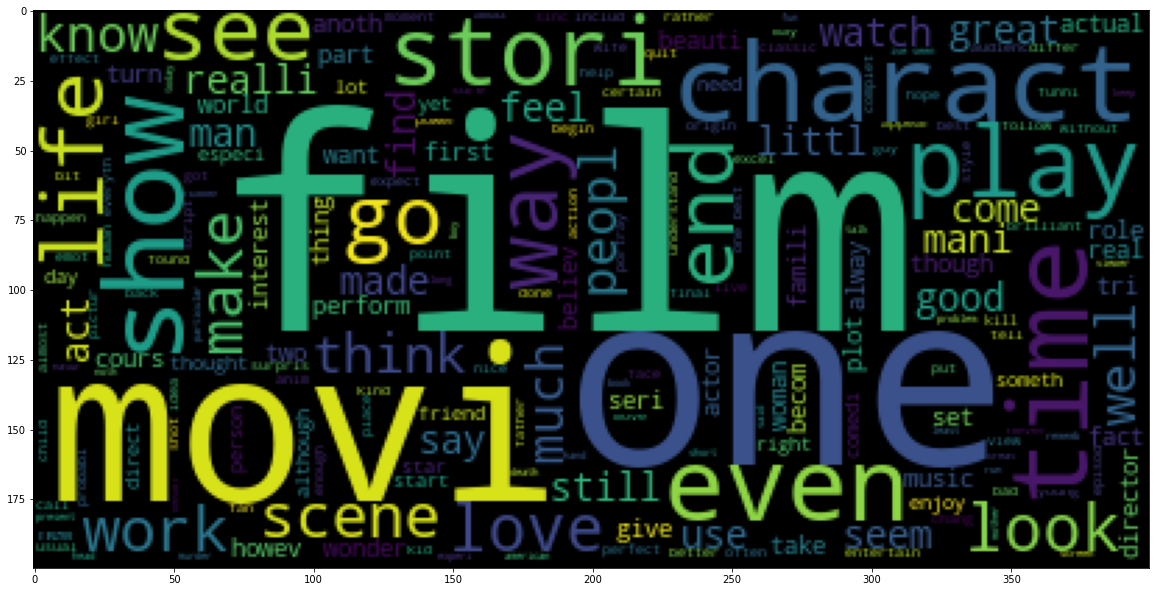

In [50]:
########################## WordCloud Positive Reviews ##################################
#Need to fix this
# Creating a list of train and test data to analyse
df_freq = df_pos
imdb_list = df_freq["review"][df_freq.label.isin(['pos'])].unique().tolist()
imdb_bow = " ".join(imdb_list)

# Create a word cloud for psitive words
imdb_wordcloud = WordCloud().generate(imdb_bow)

# Show the created image of word cloud
plt.figure(figsize=(20, 20))
plt.imshow(imdb_wordcloud)
plt.show()

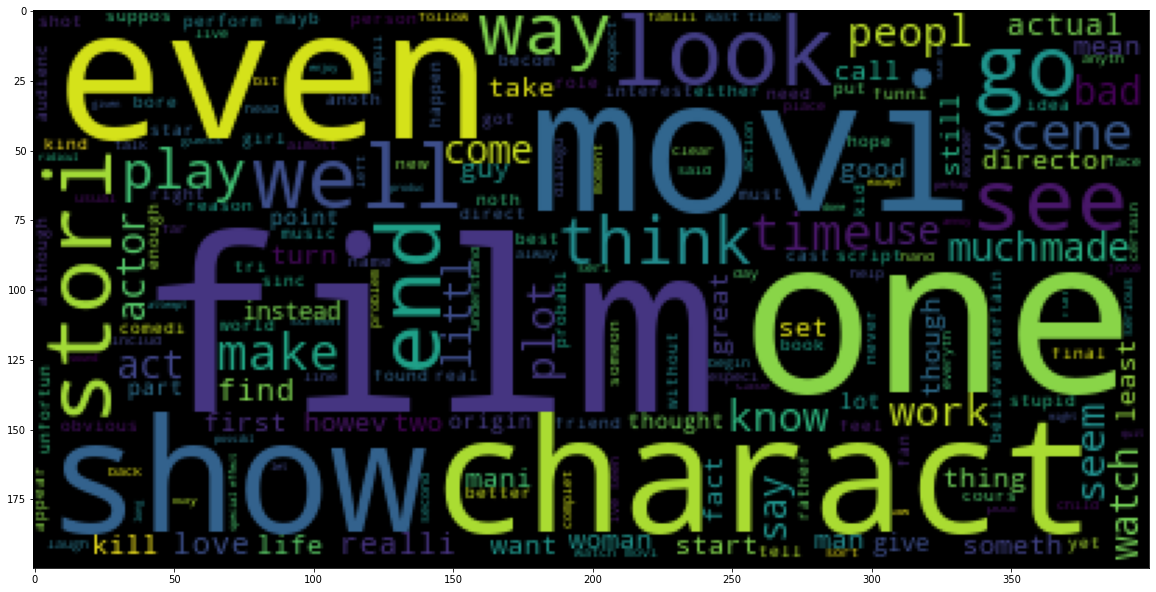

In [51]:
########################## WordCloud Negative Train & Test set ##################################

# Creating a list of train and test data to analyse
df_freq = df_neg
imdb_list = df_freq["review"][df_freq.label.isin(['neg'])].unique().tolist()
imdb_bow = " ".join(imdb_list)

# Create a word cloud for negative words
imdb_wordcloud = WordCloud().generate(imdb_bow)

# Show the created image of word cloud
plt.figure(figsize=(20, 20))
plt.imshow(imdb_wordcloud)
plt.show()

**Visualisation after feature selection**

---
Creating required dataset


In [ ]:
# Need to work from this
df_freq = pd.concat([imdb_train, imdb_test], ignore_index = True)

word_list = get_feature(df_freq, 1000)

# Removing non prefered words from training and test combined data
count = 0
for sentence in df_freq['review']:
    sentence = [word for word in sentence.lower().split() if word in word_list]
    sentence = ' '.join(sentence)
    df_freq.loc[count, 'review'] = sentence
    count+=1

In [ ]:
word_list = get_feature(df_master, 1000)
word_list

Visualisation

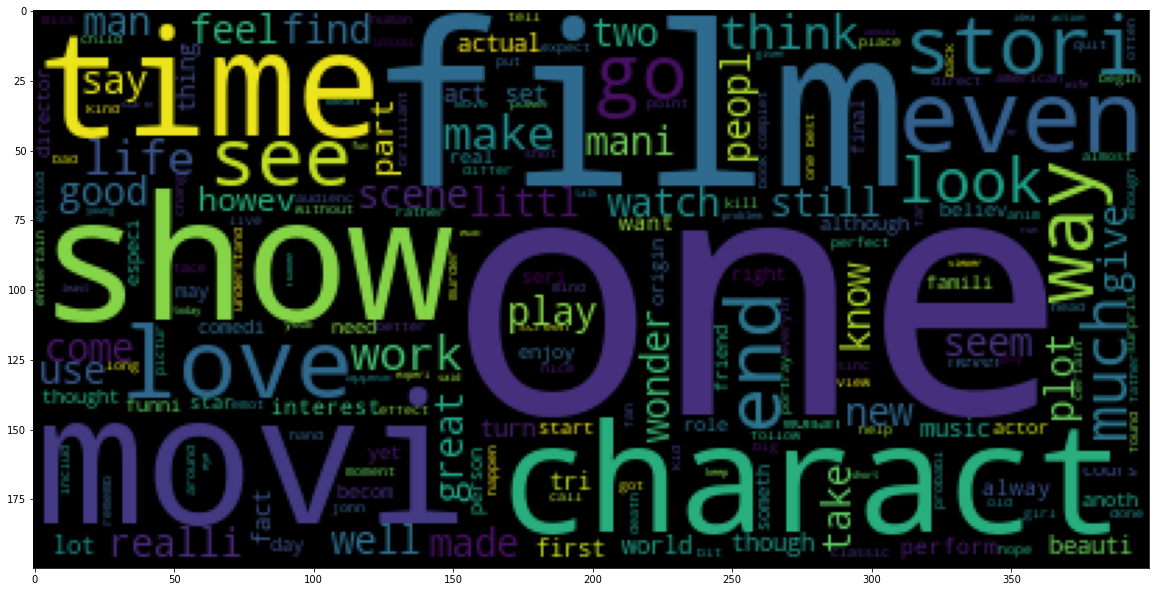

In [ ]:
########################## WordCloud Positive Train & Test set post feature selection ##################################

# Creating a list of train and test data to analyse
imdb_list = df_freq["review"][df_freq.label.isin(['pos'])].unique().tolist()
imdb_bow = " ".join(imdb_list)

# Create a word cloud for psitive words
imdb_wordcloud = WordCloud().generate(imdb_bow)

# Show the created image of word cloud
plt.figure(figsize=(20, 20))
plt.imshow(imdb_wordcloud)
plt.show()

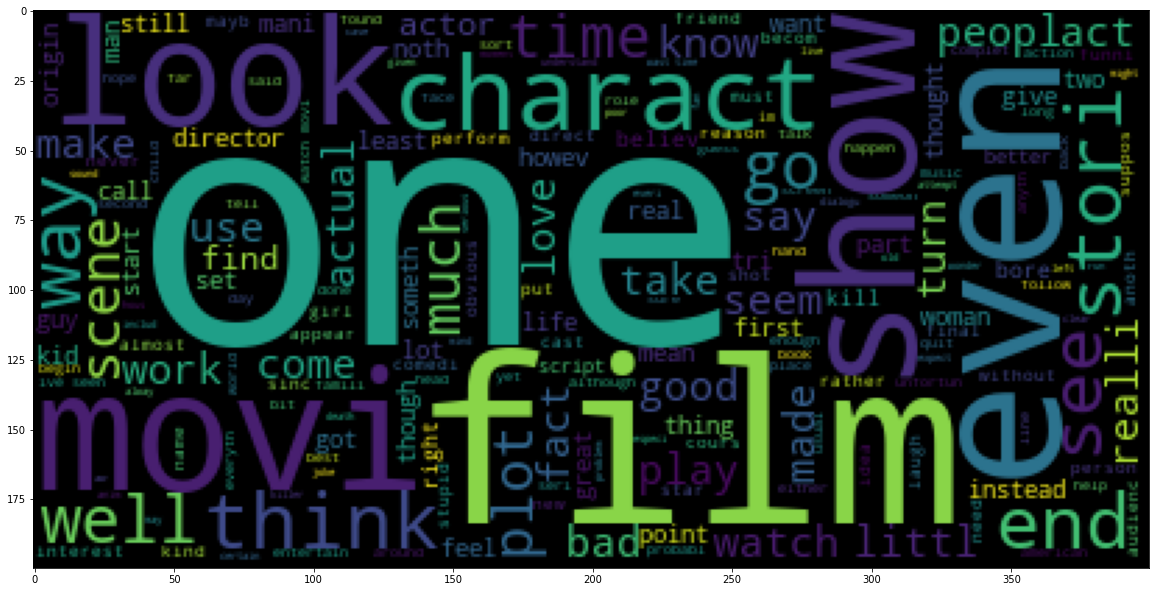

In [ ]:
########################## WordCloud Negative Train & Test set post feature selection ##################################

# Creating a list of ham data only to analyse
imdb_list = df_freq["review"][df_freq.label.isin(['neg'])].unique().tolist()
imdb_bow = " ".join(imdb_list)

# Create a word cloud for ham
imdb_wordcloud = WordCloud().generate(imdb_bow)

# Show the created image of word cloud
plt.figure(figsize=(20, 20))
plt.imshow(imdb_wordcloud)
plt.show()

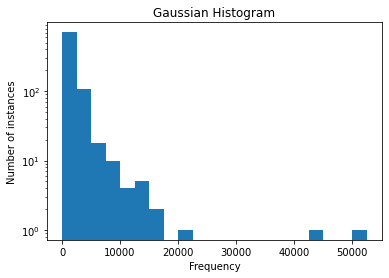

In [ ]:
########################## Histogram Positive Train & Test set post feature selection ##################################

# Creating an object for Count vectorizer and fitting it to positive dataset
hist_cv = CountVectorizer(stop_words = 'english', analyzer='word')
hist_pos = hist_cv.fit_transform(df_freq[df_freq.label.isin(['pos'])].review)

# Visualising the histogram for positive reviews only from train and dataset
data = hist_pos.sum(axis=0).tolist()
binwidth = 2500
plt.hist(data, bins=range(min(data[0]), max(data[0]) + binwidth, binwidth), log=True)
plt.title("Gaussian Histogram")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()

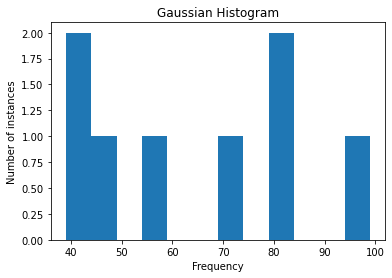

In [ ]:
# Having a look at less than 100 frequency words more closely

zoom_data = [f for f in data[0] if f <= 100]
binwidth = 5
plt.hist(zoom_data, bins=range(min(zoom_data), max(zoom_data) + binwidth, binwidth), log=False)
plt.title("Gaussian Histogram")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()

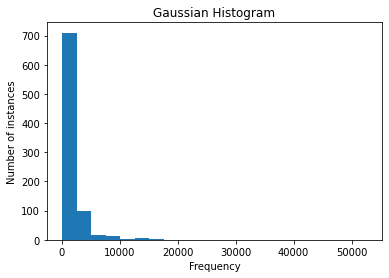

In [ ]:
# Having a look at above 100 frequency words more closely

zoom_data = [f for f in data[0] if f > 100]
binwidth = 2500
plt.hist(zoom_data, bins=range(min(zoom_data), max(zoom_data) + binwidth, binwidth), log=False)
plt.title("Gaussian Histogram")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()


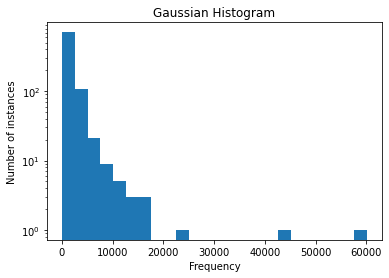

In [ ]:
########################## Histogram Negative Train & Test set post feature selection ##################################

# Creating an object for Count vectorizer and fitting it to positive dataset
hist_cv = CountVectorizer(stop_words = 'english', analyzer='word')
hist_pos = hist_cv.fit_transform(df_freq[df_freq.label.isin(['neg'])].review)

# Visualising the histogram for positive reviews only from train and dataset
data = hist_pos.sum(axis=0).tolist()
binwidth = 2500
plt.hist(data, bins=range(min(data[0]), max(data[0]) + binwidth, binwidth), log=True)
plt.title("Gaussian Histogram")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()

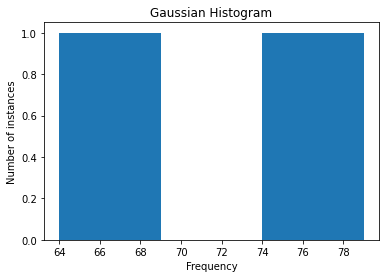

In [ ]:
# Having a look at less than 100 frequency words more closely

zoom_data = [f for f in data[0] if f <= 100]
binwidth = 5
plt.hist(zoom_data, bins=range(min(zoom_data), max(zoom_data) + binwidth, binwidth), log=False)
plt.title("Gaussian Histogram")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()

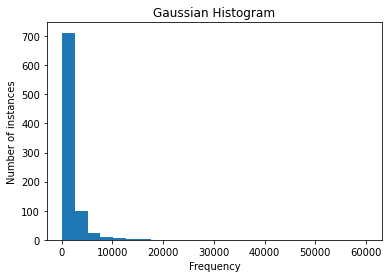

In [ ]:
# Having a look at above 100 frequency words more closely

zoom_data = [f for f in data[0] if f > 100]
binwidth = 2500
plt.hist(zoom_data, bins=range(min(zoom_data), max(zoom_data) + binwidth, binwidth), log=False)
plt.title("Gaussian Histogram")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()

Phase 3: Model Building post Hypothesis Testing (Naive Bayes for Supervised Learning and K-Means for Unsupervised Learning)

In [ ]:
imdb_unsup = df_master[["review", "label"]][df_master.label.isin(['unsup'])].reset_index(drop=True)

# Cleaning Unlabelled data

imdb_unsup['review'] = rem_sw(imdb_unsup['review'])
imdb_unsup['review'] = rem_punc(imdb_unsup['review'])
imdb_unsup['review'] = lemma(imdb_unsup['review'])
imdb_unsup['review'] = stemma(imdb_unsup['review'])

# Vectorizing unlabelled reviews set
vect = CountVectorizer(stop_words = 'english', analyzer='word')
vect_pos = vect.fit_transform(imdb_unsup.review)

# Creating a dataframe for the high frequency words for unlabelled reviews set
df_freq = pd.DataFrame(vect_pos.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T

# Removing high frequency and low frequency data for more accuracy
word_list = df_freq.nlargest(100, 'frequency').index
word_list = word_list.append(df_freq.nsmallest(43750, 'frequency').index)

# Removing unwanted words based on word_list from unlabelled data
count = 0
for sentence in imdb_unsup['review']:
    sentence = [word for word in sentence.lower().split() if word not in word_list]
    sentence = ' '.join(sentence)
    imdb_unsup.loc[count, 'review'] = sentence
    count+=1

################################## Preparing dataframe for model ##############################

# Creating df_algo dataframe which will be used for hypothesis testing
df_algo = pd.concat([imdb_train, imdb_test], keys=['train', 'test'])
df_algo = df_algo.reset_index(col_level=1).drop(['level_1'], axis=1)

# Cleaning the dataset
df_algo['review'] = rem_sw(df_algo['review'])
df_algo['review'] = rem_punc(df_algo['review'])
df_algo['review'] = lemma(df_algo['review'])
df_algo['review'] = stemma(df_algo['review'])

# df_algo = pd.read_csv("clean_algo.csv", encoding='latin-1', index_col = 0) # Uncomment this line to load from csv

################################### Removing non feature words ###############################

# Creating the feature word_list
# Selecting 14440 feature selected words based on 80-20 rule
word_list = get_feature(df_algo[['review', 'label']], 14440)

# Removing non prefered words from training and test combined data
count = 0
for sentence in df_algo['review']:
    sentence = [word for word in sentence.lower().split() if word in word_list]
    sentence = ' '.join(sentence)
    df_algo.loc[count, 'review'] = sentence
    count+=1

################################## Splitting with feature selection data ###############################a

# Vectorising the required data
vect_algo = TfidfVectorizer(stop_words='english', analyzer='word')
vect_algo.fit(df_algo.review)
Xf_train = vect_algo.transform(df_algo[df_algo['level_0'].isin(['train'])].review)
Xf_test = vect_algo.transform(df_algo[df_algo['level_0'].isin(['test'])].review)

# Encoding target data
# Creating an object and fitting on target strings
le = LabelEncoder()
yf_train = le.fit_transform(df_algo[df_algo['level_0'].isin(['train'])].label)
yf_test = le.fit_transform(df_algo[df_algo['level_0'].isin(['test'])].label)

########################################### Naive Bayes #########################################

# Fit the Naive Bayes classifier model to the object
clf = MultinomialNB()
clf.fit(Xf_train, yf_train)

# predict the outcome for testing data
predictions = clf.predict(Xf_test)

# check the accuracy of the model
accuracy = accuracy_score(yf_test, predictions)
print("Observation: Naive Bayes Classification gives an accuracy of %.2f%% on the testing data" %(accuracy*100))

Observation: Naive Bayes Classification gives an accuracy of 1.35% on the testing data


Unsupervised Learning: Kmeans

Selecting 100 largest and 43750 lowest frequency words for Unsupervised learning. The numbers have been decided based on numerous iterations done during Hypothesis testing. These numbers gave the most distinct clusters.

In [ ]:
##################################### Using K-means to create two clusters ##################################### 

# Vectorizing dataset
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(imdb_unsup.review)
 
# Creating a k-means object and fitting it to target variable
true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)
 
# Visualising the 2 clusters
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 beauti
 famili
 alway
 excel
 differ
 war
 american
 live
 perfect
 saw
Cluster 1:
 worst
 wast
 bore
 laugh
 poor
 terribl
 stupid
 aw
 budget
 horribl


In [ ]:
# Prediction for test set using Kmeans clusters
Y = vectorizer.transform(imdb_test.review)
prediction = model.predict(Y)

# Actual results of test sets for comparison
le = LabelEncoder()
y = le.fit_transform(imdb_test.label)

# check the accuracy of the model
accuracy = accuracy_score(y, prediction)
if accuracy < 0.5:
    accuracy = 1 - accuracy
print("Observation: The unsupervised learning gives an accuracy of %.2f%% on the testing data" %(accuracy*100))

Observation: The unsupervised learning gives an accuracy of 72.55% on the testing data


Dividing the data into more clusters to enable finding more classes. Using Cluster divisions to derive movie genres from review.

In [ ]:
imdb_unsup = df_master[["review", "label"]][df_master.label.isin(['unsup'])].reset_index(drop=True)

# Cleaning Unlabelled data

imdb_unsup['review'] = rem_sw(imdb_unsup['review'])
imdb_unsup['review'] = rem_punc(imdb_unsup['review'])
imdb_unsup['review'] = lemma(imdb_unsup['review'])
imdb_unsup['review'] = stemma(imdb_unsup['review'])

# Vectorizing unlabelled reviews set
vect = CountVectorizer(analyzer='word')
vect_pos = vect.fit_transform(imdb_unsup.review)

# Creating a dataframe for the high frequency words for unlabelled reviews set
df_freq = pd.DataFrame(vect_pos.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T

# Removing high frequency and low frequency data for more accuracy

word_list = df_freq.nlargest(100, 'frequency').index
word_list = word_list.append(df_freq.nsmallest(43750, 'frequency').index)

# Removing unwanted words based on word_list from unlabelled data
count = 0
for sentence in imdb_unsup['review']:
    sentence = [word for word in sentence.lower().split() if word not in word_list]
    sentence = ' '.join(sentence)
    imdb_unsup.loc[count, 'review'] = sentence
    count+=1
    
##################################### Using K-means to create clusters ##################################### 

# Vectorizing dataset
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(imdb_unsup.review)
 
# Creating a k-means object and fitting it to target variable
true_k = 9
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1, random_state=13)
model.fit(X)
 
# Visualising the clusters
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 music
 origin
 fan
 wonder
 john
 fun
 excel
 big
 saw
 quit
Cluster 1:
 book
 read
 novel
 adapt
 version
 chang
 base
 origin
 seri
 disappoint
Cluster 2:
 comedi
 laugh
 joke
 romant
 humor
 hilari
 grant
 sandler
 fun
 expect
Cluster 3:
 horror
 zombi
 gore
 dead
 scari
 effect
 kill
 flick
 slasher
 budget
Cluster 4:
 war
 famili
 american
 person
 beauti
 child
 young
 human
 emot
 live
Cluster 5:
 episod
 seri
 game
 season
 tv
 fan
 origin
 dvd
 televis
 ive
Cluster 6:
 worst
 wast
 minut
 bore
 terribl
 poor
 ive
 script
 aw
 money
Cluster 7:
 kid
 child
 famili
 adult
 parent
 school
 boy
 saw
 rememb
 laugh
Cluster 8:
 anim
 cartoon
 disney
 bambi
 voic
 origin
 seri
 music
 short
 child


In [18]:
##################### Seperating the data in to train and test set #############################
imdb_test = df_master.query('type=="test" & label !="unsup"')
imdb_test.head()

,type,review,label,file
0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [17]:
##################### Seperating the data in to train and test set #############################
imdb_train = df_master.query('type=="train" & label !="unsup"')
imdb_train.head()

,type,review,label,file
25000,train,Story of a man who has unnatural feelings for ...,neg,0_3.txt
25001,train,Airport '77 starts as a brand new luxury 747 p...,neg,10000_4.txt
25002,train,This film lacked something I couldn't put my f...,neg,10001_4.txt
25003,train,"Sorry everyone,,, I know this is supposed to b...",neg,10002_1.txt
25004,train,When I was little my parents took me along to ...,neg,10003_1.txt
